# Mixed Layer Instability

This notebook implements the eigenvalue problem posed in 

[Boccaletti, Ferrari, & Fox-Kemper, 2007: 
Journal of Physical Oceanography, 37, 2228-2250.](https://journals.ametsoc.org/view/journals/phoc/37/9/jpo3101.1.xml?tab_body=fulltext-display)

This demonstrates the use of the `grow_func` option to Eigenproblem to specify a custom calculation method for determining the growth rate of a given eigenvalue.

This script also gives an example of using `project_mode` to compute a 2D visualization of the most unstable eigenmode.

In [1]:
import numpy as np
import matplotlib.pylab as plt
from eigentools import Eigenproblem, CriticalFinder
import dedalus.public as de
from dedalus.extras import plot_tools

In [2]:
# problem parameters
kx = 0.8  # x-wavelength
ky = 0    # y-wavelength
δ = 0.1   # Prandtl ratio f/N
Ri = 2    # Richardson number
L = 1     # Characteristic length scale along front
Hy = 0.05 # Vertical scale
ΔB = 10   # Buoyancy jump at bottom of mixed layer

# discretization parameters
nz = 32
nx = 32 # only necessary for 2D visualization

In [3]:
# Only need the z direction to compute eigenvalues
z = de.Chebyshev('z',nz, interval=[-1,0])
d = de.Domain([z], grid_dtype=np.complex128)

evp = de.EVP(d, ['u','v','w','p','b'],'sigma')

evp.parameters['Ri'] = Ri
evp.parameters['δ'] = δ
evp.parameters['L'] = L
evp.parameters['Hy'] = Hy
evp.parameters['ΔB'] = ΔB
evp.parameters['kx'] = kx
evp.parameters['ky'] = ky
evp.substitutions['dt(A)'] = '1j*sigma*A'
evp.substitutions['dx(A)'] = '1j*kx*A'
evp.substitutions['dy(A)'] = '1j*ky*A'
evp.substitutions['U'] = 'z + L'

evp.add_equation('dt(u) + U*dx(u) + w - v + Ri*dx(p) = 0')
evp.add_equation('dt(v) + U*dx(v)     + u + Ri*dy(p) = 0')
evp.add_equation('Ri*δ**2*(dt(w) + U*dx(w)) - Ri*b  + Ri*dz(p) = 0')
evp.add_equation('dt(b) + U*dx(b) - v/Ri + w = 0')
evp.add_equation('dx(u) + dy(v) + dz(w) = 0')

evp.add_bc('right(w) = 0')
evp.add_bc('left(w + dt(p/ΔB) - Hy*v) = 0')

2021-01-04 13:15:58,222 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


Because the notion of *stability* depends on the assumed time dependence and there are several widely used conventions, `eigentools` allows users to define what "growth" and "frequency" mean in the context of their problem. This is done by passing `grow_func` and `freq_func` to `Eigenproblem`. These functions take a complex number z and return the "growth" and "frequency" corresponding to it.

In this problem the time dependence is given by

$$e^{i \sigma t},$$

so the growth rate is $-Im(\sigma)$ and the frequency is $Re(\sigma)$.

In [4]:
g_func = lambda z: -z.imag
f_func = lambda z: z.real
EP = Eigenproblem(evp, grow_func=g_func, freq_func=f_func)

2021-01-04 13:15:58,280 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


The `EP.growth_rate()` method will provide the eigenvalue corresponding to the fastest growing mode, as defined by `grow_func`. Here, we use `sparse=False` because this is an ideal problem with many exactly zero eigenvalues, the fastest growing mode is never closest to zero. Thus, we must either provide a guess or use the dense solver.

In [5]:
rate, indx, freq = EP.growth_rate(parameters={'Hy':Hy, 'kx': kx}, sparse=False)
print("fastest growing mode: {} @ freq {}".format(rate, freq))

fastest growing mode: 0.19931003960491872 @ freq -0.33556838187371807


`EP.growth_rate` also provides `indx`, which is the index to the most unstable eigenmode. We can then use that to access that eigenmode for visualization.

Because the eigenvalue problems solved by Dedalus are one-dimensional, `eigentools` provides a simple method to visualize all of the modes. In general, these solutions are complex, with the real and imaginary parts of each variable determining their phase relationships. Because eigenmodes are only defined to a relative phase, `EP.plot_mode` allows the user to specify a variable to normalize against. All variables are multiplied by the complex conjugate of the chosen mode. Here, we have chosen the vertical velocity `w`. Note that its plot shows no imaginary part.

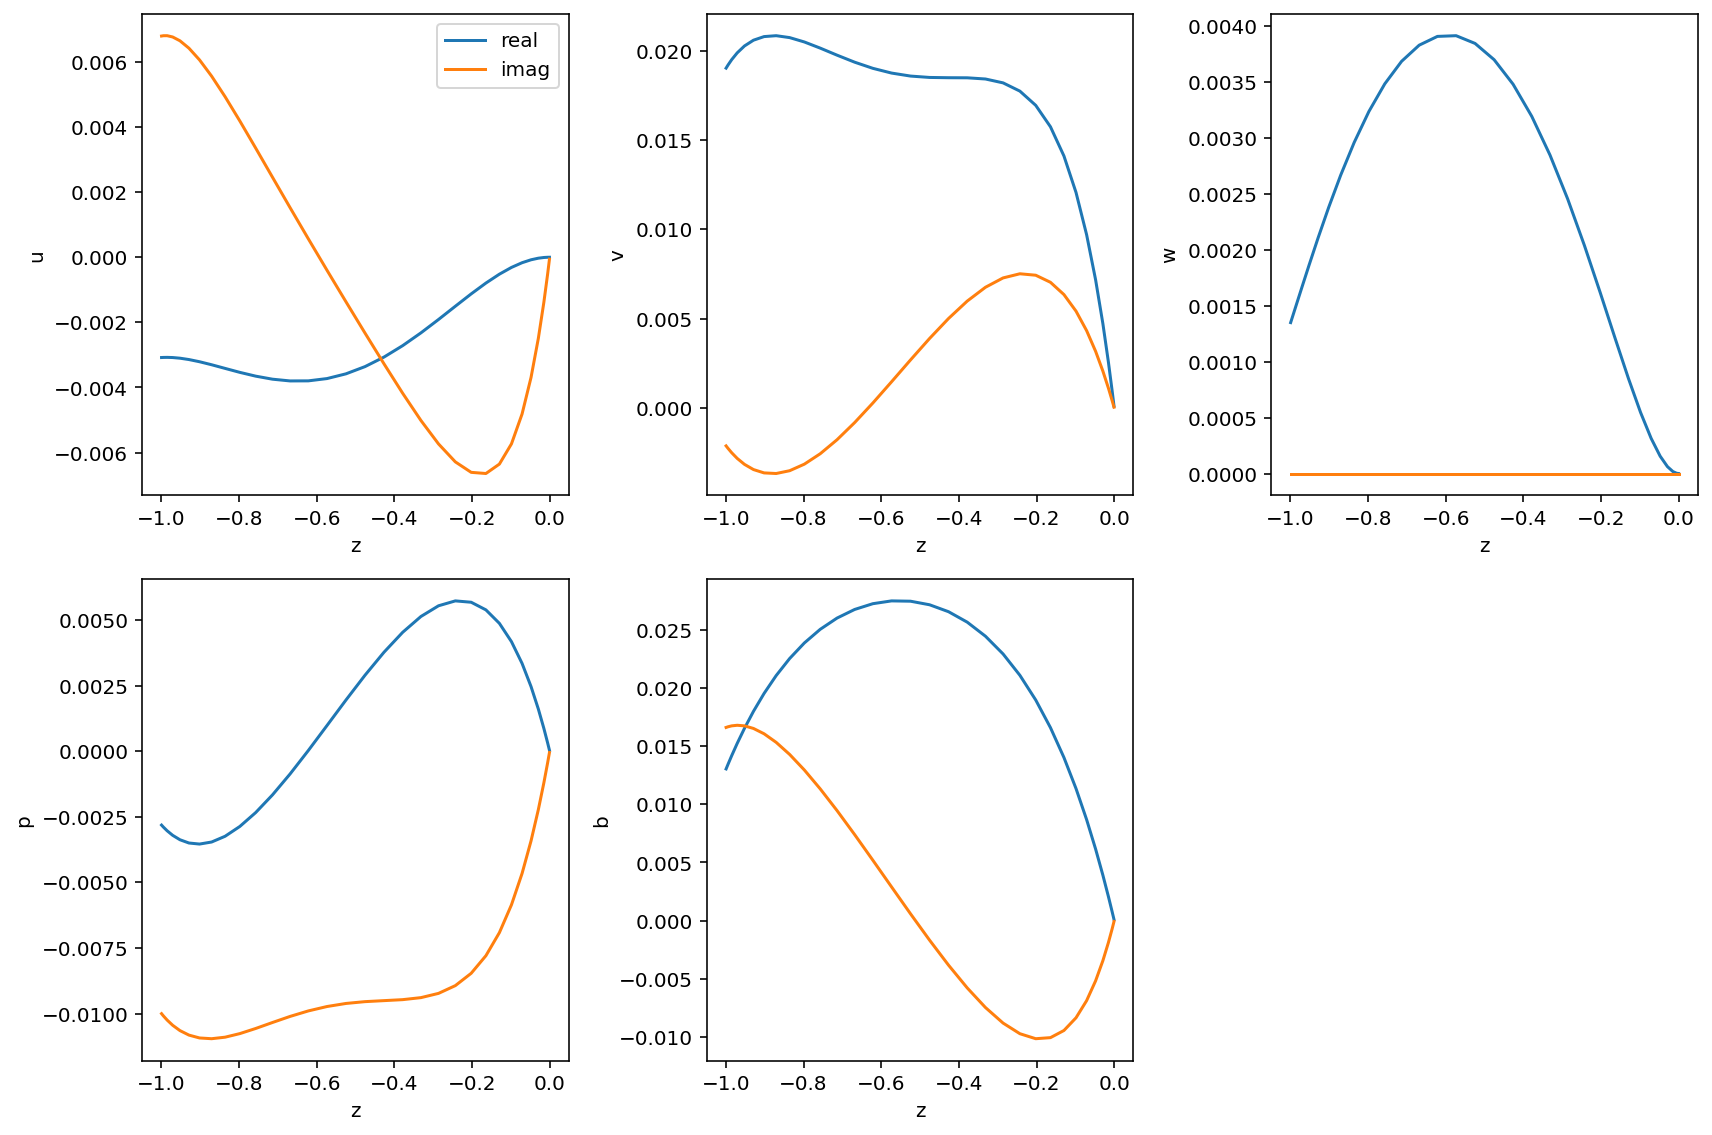

In [6]:
fig = EP.plot_mode(indx, norm_var='w')
fig.savefig('mixed_layer_unstable_1D.png')

However, because this is a 2-D problem with $e^{i k x}$ dependence in $x$, we often want to visualize this mode in 2-D also. In order to do so, we define a 2-D domain using Dedalus with the $x$ direction added. Note that *this* domain has a grid dtype of `np.float64` because once we project against the complex exponential in $x$, the various fields in the eigenmode become real variables.

In [7]:
# define a 2D domain to plot the eigenmode
x = de.Fourier('x',nx)
d_2d = de.Domain([x,z], grid_dtype=np.float64)

Next we will produce a 2-D plot of the most unstable eigenmode shown in figure 7 from Boccaletti, Ferrari, and Fox-Kemper (2007). 

First we must *project* the eigenmode against the 2-D domain using `EP.project_mode`. Again we specify the mode index using `indx` and then specify the transverse mode; here we choose 1 so that we do not need to scale $L_x$.

In [8]:
fs = EP.project_mode(indx, d_2d, (1,))

`EP.project_mode()` returns a Dedalus `FieldSystem` object holding all of the variables in the problem. It can then be accessed using the familiar `fs['u']['g']` interface to get the grid space representation of the x-velocity $u$.

Below, we use Dedalus's `plot_tools` to help generate the plots.

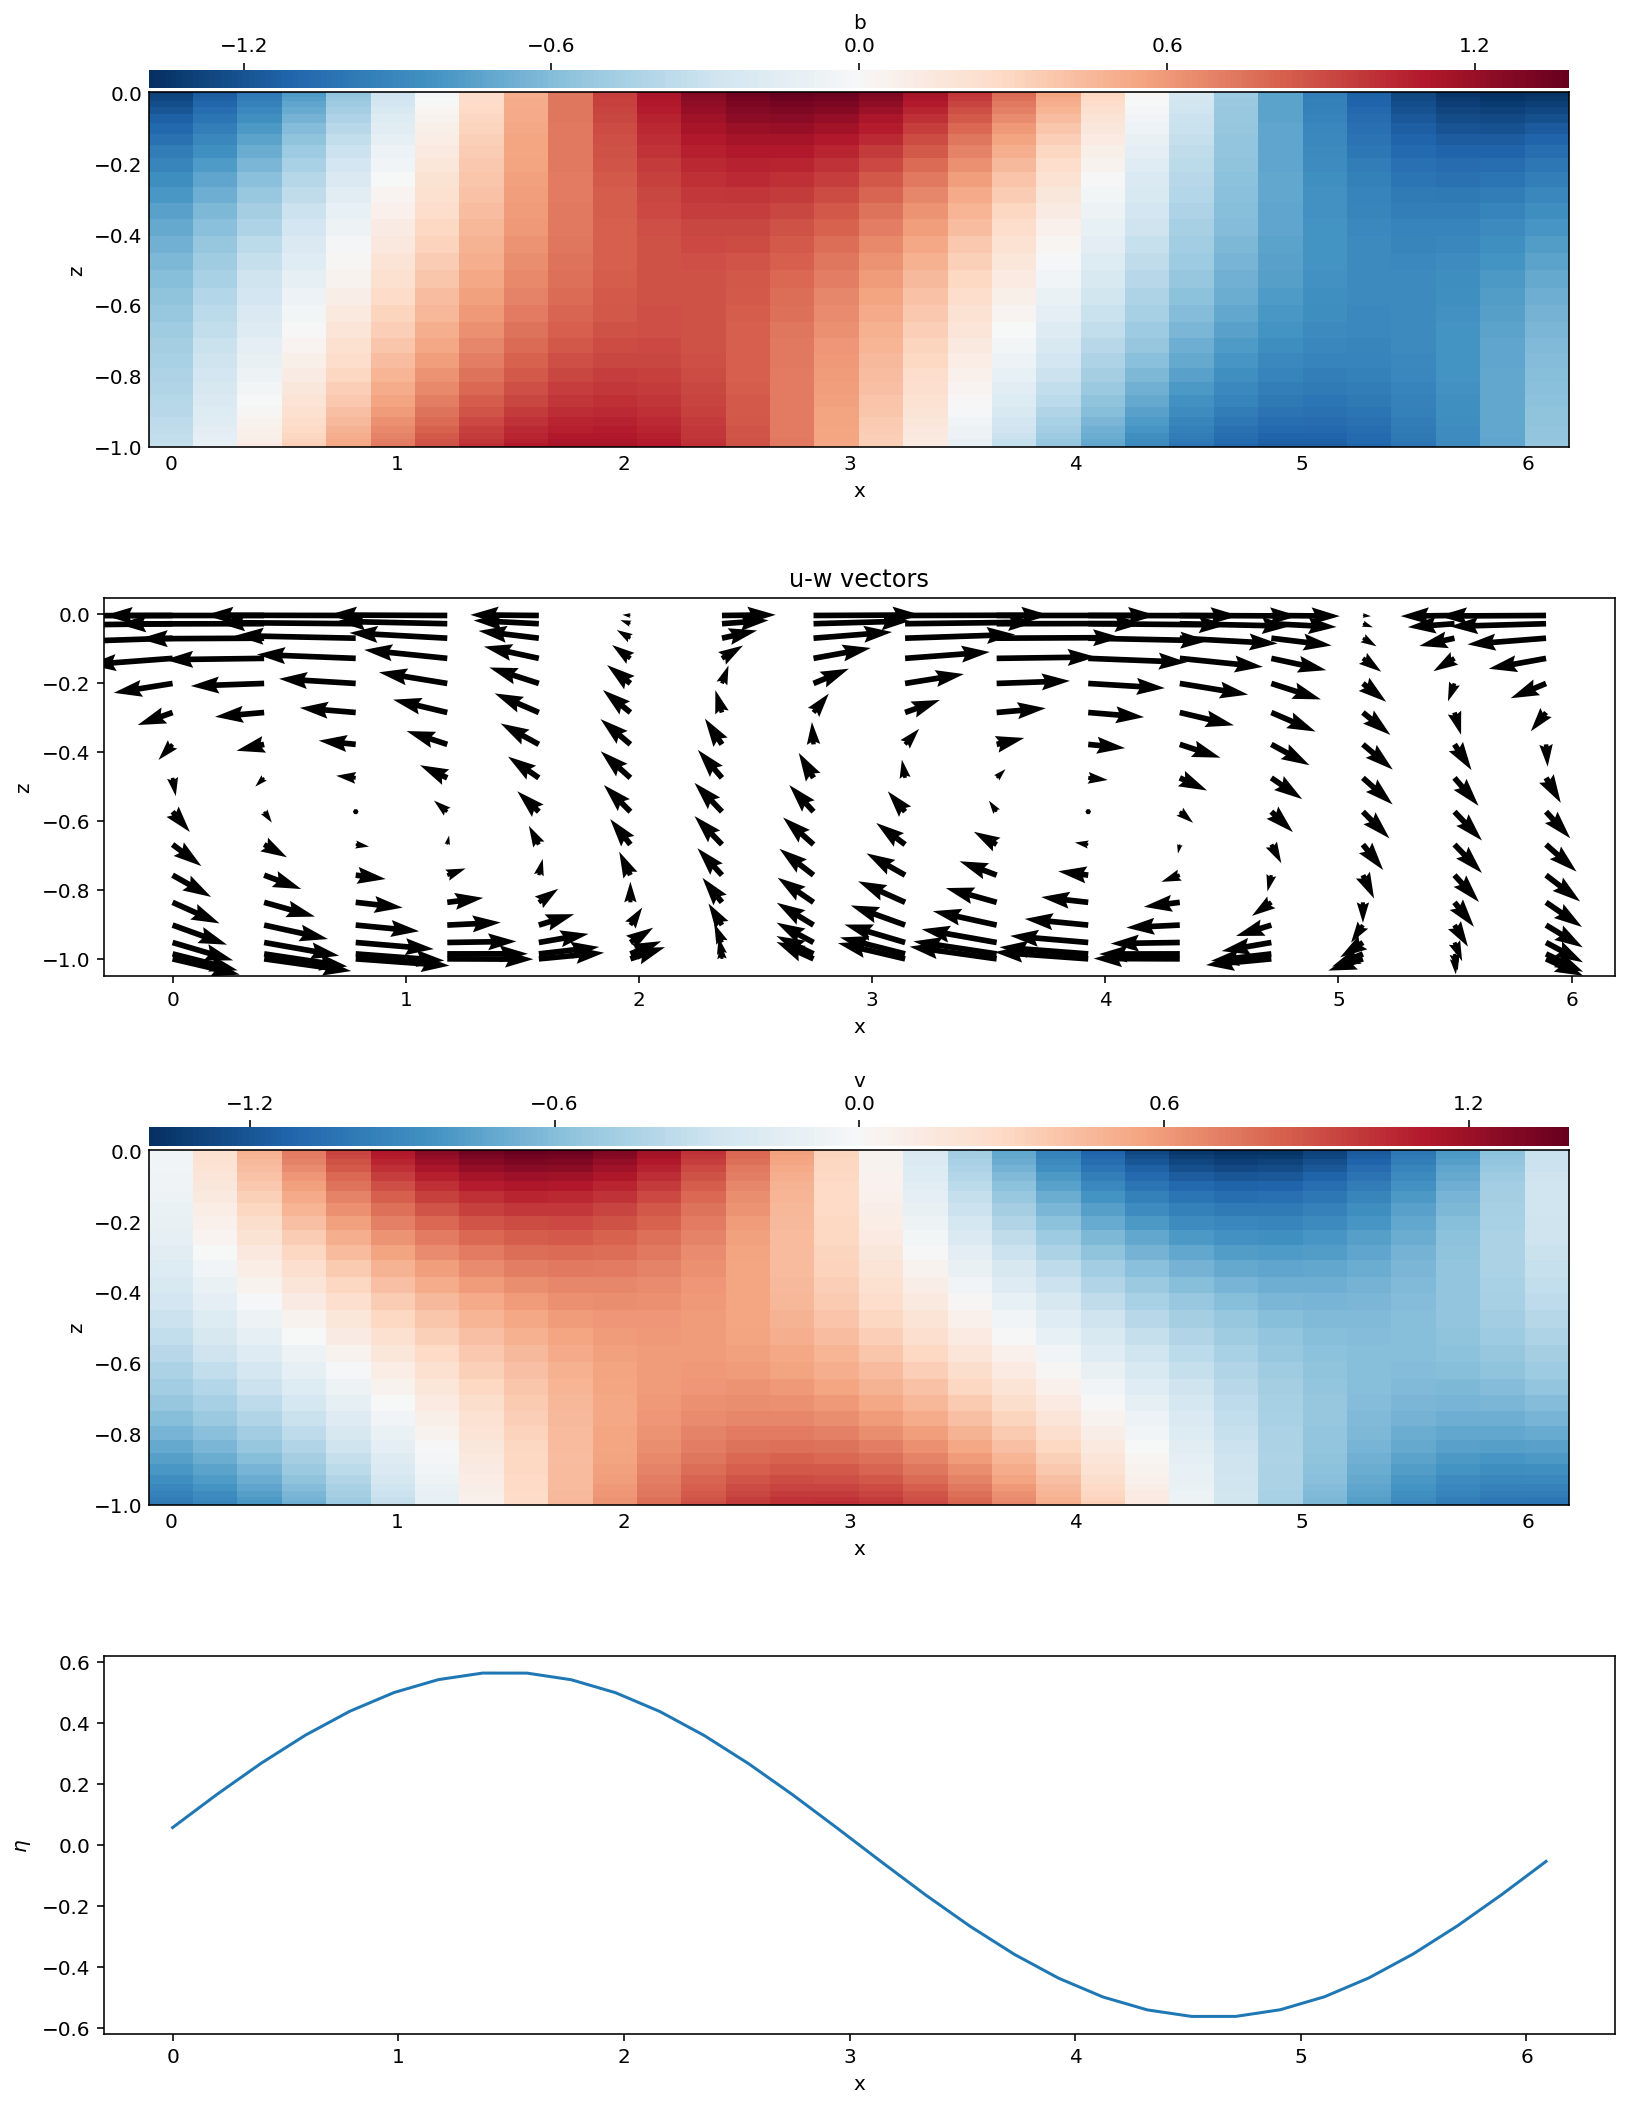

In [9]:
scale=2.5
nrows = 4
ncols = 1
image = plot_tools.Box(4, 1)
pad = plot_tools.Frame(0.2, 0.2, 0.1, 0.1)
margin = plot_tools.Frame(0.3, 0.2, 0.1, 0.1)
mfig = plot_tools.MultiFigure(nrows, ncols, image, pad, margin, scale)
fig = mfig.figure

for var in ['b','u','v','w','p']:
    fs[var]['g']

# b
axes = mfig.add_axes(0,0, [0,0,1,1])
plot_tools.plot_bot_2d(fs['b'], axes=axes)

# u,w
axes = mfig.add_axes(1,0, [0,0,1,1])
data_slices = (slice(None), slice(None))
xx,zz = d_2d.grids()
xx,zz = np.meshgrid(xx,zz)
axes.quiver(xx[::2,::2],zz[::2,::2], fs['u']['g'][::2,::2].T, fs['w']['g'][::2,::2].T,zorder=10)
axes.set_xlabel('x')
axes.set_ylabel('z')
axes.set_title('u-w vectors')

# v
axes = mfig.add_axes(2,0, [0,0,1,1])
plot_tools.plot_bot_2d(fs['v'], axes=axes)

# eta
axes = mfig.add_axes(3,0, [0,0,1,1])
axes.plot(xx[0,:],-fs['p']['g'][:,0])
axes.set_xlabel('x')
axes.set_ylabel(r'$\eta$')

fig.savefig('mixed_layer_unstable_2D.png',dpi=300)

Next, we will look at the stability portrait for these parameters as a function of $k_x$ and $H_y$. Eigentools provides `CriticalFinder` as an interface for doing this. We are only going to use the grid generation function, which runs a number of eigenvalue problems at different parameters. 

First, we define a set of points in each dimension, $k_x$ and $H_y$ using `np.linspace`. We then use `cf.grid_generator` to run an eigenvalue problem at each specified $k_x, H_y$ point and return its growth rate. This can be run in parallel via MPI; here we'll do a very coarse grid of just 10 by 10. This takes approximately 1 minute on a single core of a 2020 Core i7.

Because the this is a time consuming process, but plotting the data is fast and may require iteration, `cf.save_grid` saves the data to an HDF5 file. There is a corresponding `cf.load_grid` method that will load in such a file.

In [10]:
cf = CriticalFinder(EP, ("kx","Hy"), find_freq=False)
nx = 10
ny = 10
xpoints = np.linspace(0.01, 1.6, nx)
ypoints = np.linspace(-0.05,0.05,ny)

cf.grid_generator((xpoints,ypoints))
cf.save_grid('mixed_layer_grid')

2021-01-04 13:16:01,417 criticalfinder 0/1 INFO :: Solving Local EVP 1/100
2021-01-04 13:16:01,689 criticalfinder 0/1 INFO :: Solving Local EVP 2/100
2021-01-04 13:16:01,969 criticalfinder 0/1 INFO :: Solving Local EVP 3/100
2021-01-04 13:16:02,232 criticalfinder 0/1 INFO :: Solving Local EVP 4/100
2021-01-04 13:16:02,501 criticalfinder 0/1 INFO :: Solving Local EVP 5/100
2021-01-04 13:16:02,779 criticalfinder 0/1 INFO :: Solving Local EVP 6/100
2021-01-04 13:16:03,056 criticalfinder 0/1 INFO :: Solving Local EVP 7/100
2021-01-04 13:16:03,338 criticalfinder 0/1 INFO :: Solving Local EVP 8/100
2021-01-04 13:16:03,620 criticalfinder 0/1 INFO :: Solving Local EVP 9/100
2021-01-04 13:16:03,913 criticalfinder 0/1 INFO :: Solving Local EVP 10/100
2021-01-04 13:16:04,222 criticalfinder 0/1 INFO :: Solving Local EVP 11/100
2021-01-04 13:16:04,487 criticalfinder 0/1 INFO :: Solving Local EVP 12/100
2021-01-04 13:16:04,745 criticalfinder 0/1 INFO :: Solving Local EVP 13/100
2021-01-04 13:16:05,0

Finally, we produce a plot comparable to the left panel of figure 6 in [Boccaletti, Ferrari, & Fox-Kemper (2007)](https://journals.ametsoc.org/view/journals/phoc/37/9/jpo3101.1.xml?tab_body=fulltext-display).

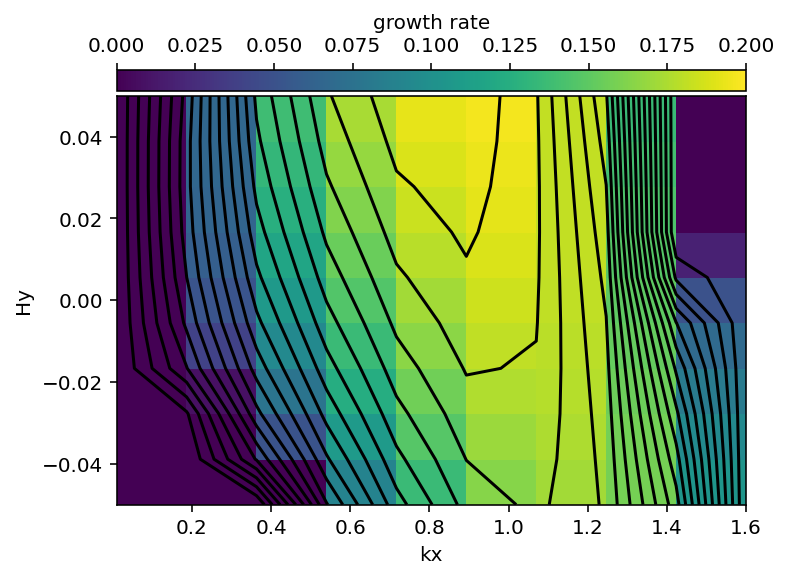

In [16]:
pax,cax = cf.plot_crit()
pax.collections[0].set_clim(0,0.2)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
contours = np.linspace(0,0.2,20,endpoint=False)
pax.contour(cf.parameter_grids[0], cf.parameter_grids[1],cf.evalue_grid.real, levels=contours, colors='k')
pax.figure.savefig('mixed_layer_growth_rates.png',dpi=300)